## Orthogonal Matching Pursuit

In [570]:
import sys
import itertools

from tqdm import tqdm

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Orthogonal matching
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

sys.path.append("..")
import helper.helper as h

### Generate Matrix $A$
We generate a (non-strictly) lower triangular matrix $A$ with $\texttt{num\_edges}$ edges. The weights of these edges are uniformly chosen from $[-a_{\text{high}}, -low_{\text{low}}] \cup [low_{\text{low}}, high_{\text{high}}]$. Note that $\texttt{num\_edges}$ must be between zero and $n (n + 1) / 2$.

In [571]:
def generate_A(n, num_edges, low = 0.5, high = 2.0, tril = False):
    edges = np.array([0.0] * (int(n * (n + 1) / 2) - num_edges -n * tril) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(low, high, num_edges)
    np.random.shuffle(edges)
    
    A = np.zeros((n, n))
    
    A[np.tril_indices(n, - tril)] = edges
    
    return A

### Generate data
Generate $\texttt{T}$ samples of $\texttt{n}$ dimensions, where $A$ is generated as above with $\texttt{s}$ edges. The weighted adjacency matrix $\texttt{W_true}$ is generated by permuting the rows and columns of $A$ with a random permutation $\texttt{P_true}$.

A:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.03  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.87 -1.61  0.    0.    0.    0.    0.    0.    0.  ]
 [-1.41  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.99 -0.62  0.   -1.82  0.94  0.    0.    0.    0.    0.  ]
 [ 0.    1.37  0.   -1.48  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.66 -1.89 -0.71  0.    1.92 -1.71  0.    0.    0.  ]
 [-0.56  0.   -1.27  0.68  0.    1.28  1.52  0.    0.    0.  ]
 [ 0.    0.    1.53  0.99 -1.01 -1.83  0.    0.    0.    0.  ]]

P:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]].

W:
[[ 0.    0.    0.    0.   

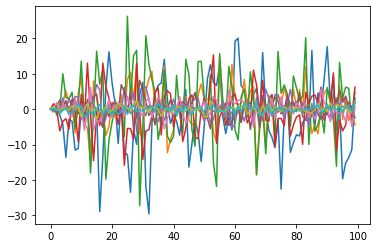

In [619]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 10, 25

# score threshold
score_threshold = 0.25

## Coefficient matrix
A_true = generate_A(n, s, tril = True)

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

W_true = P_true.T @ A_true @ P_true

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

# get X value and X prediction
X_val = X[1:]
X_pred = X[:-1]

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n\nW:\n{np.round(W_true, 2)}")

In [620]:
print(np.sum((X_val[:, 0] - X_pred @ np.zeros(n)) ** 2, axis = 0))
print(np.sum((X_val[:, 0] - X_pred @ W_OMP[:, 0]) ** 2, axis = 0))

10326.66993895618
10326.66993895618


### Orthogonal Matching Pursuit with $n_{\text{nonzero\_coefs}}$ constraint

We have $$X_{t+1} = X_tW + E,$$
where $X_t \in \mathbb{R}^n$. Or equivalently,
$$X_{i, t+1} = X_{i, t}W_i + E_i,\qquad \forall i = 1, \cdots, n.$$
We seek to solve

$$\underset{w_i}{\operatorname{arg\,min\,}}  ||X_{i, t+1} - X_{i, t}w_i||_2^2 \text{ subject to } ||w_i||_0 \leq n_{\text{nonzero\_coefs}},\qquad \forall i = 1, \cdots, n.$$
In English, we are looking for the variables $X_1, ..., X_{n_{\text{nonzero\_coefs}}}$ such that the $2$-norm squared is minimal. If $n_\text{nonzero\_coefs}$ is equal to one for example, we are looking for the variable $X_i$ that minimizes the $2$-norm squared. 

In [621]:
# define number of non zero coefficients
n_nonzero_coefs = 2

# define orthogonal matching pursuit with corss validation
omp = OrthogonalMatchingPursuit(n_nonzero_coefs = n_nonzero_coefs)

# define weighted adjacency matrix
# start with zeros so that we can vstack rows
W_OMP = np.array(np.zeros(n))

# for each variable X_i
for i in range(n):
    # use X_t+1 to estimate X_{i, t}
    omp_fit = omp.fit(X_pred, X_val[:, i])
    omp_score = omp_fit.score(X_pred, X_val[:, i])
    if omp_score > -0.01:
        W_OMP = np.vstack((W_OMP, omp_fit.coef_))
    else:
        W_OMP = np.vstack((W_OMP, np.zeros(n)))
        
    print(f"Score of column {i + 1}: {round(omp_fit.score(X_pred, X_val[:, i]), 3)}.")
    
# remove first row with all zeros
W_OMP = W_OMP[1:].T

# print results, print wether it it a DAG
print(f"\nW_OMP with {n_nonzero_coefs} nonzero coefficients:\n{np.round(W_OMP, 2)}.\n\nW_true:\n{np.round(W_true, 2)}.\n")

compare(W_OMP, W_true)

Score of column 1: 0.702.
Score of column 2: 0.888.
Score of column 3: 0.953.
Score of column 4: 0.913.
Score of column 5: 0.871.
Score of column 6: 0.714.
Score of column 7: 0.827.
Score of column 8: 0.087.
Score of column 9: 0.033.
Score of column 10: 0.048.

W_OMP with 2 nonzero coefficients:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.02]
 [-0.45  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.84 -1.6   0.    0.    0.    0.    0.    0.    0.  ]
 [-2.45  0.    0.    0.    0.    0.    0.    0.    0.04  0.  ]
 [ 0.    0.    0.   -1.81  0.88  0.    0.    0.   -0.06  0.  ]
 [ 0.    1.58  0.   -1.52  0.    0.    0.    0.09  0.    0.  ]
 [ 0.    0.   -2.14  0.    0.    1.83 -1.66  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.51  0.23  0.    0.  ]
 [ 0.    0.    0.    0.   -1.2  -1.76  0.    0.    0.   -0.18]].

W_true:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]

### Orthogonal Matching Pursuit using maximum tolerance

We have $$X_{t+1} = X_tW + E,$$
where $X_t \in \mathbb{R}^n$. Or equivalently,
$$X_{i, t+1} = X_{i, t}W_i + E_i,\qquad \forall i = 1, \cdots, n.$$
We seek to solve

$$\underset{w_i}{\operatorname{arg\,min\,}} ||w_i||_0 \text{ subject to } ||X_{i, t+1} -X_{i, t}w_i||_2^2 \leq \text{tol},\qquad \forall i = 1, \cdots, n.$$
In English, we are looking for the smallest number of variables $X_1, ..., X_{n_{\text{nonzero\_coefs}}}$ such that we can reach a residual lower than the tolerance. 

#### Value for tol
The value for the tolerance is very important. If the tolerance is too low, then the OMP algorithm is very strict. In the extreme case, if we allow for $\textit{zero}$ tolerance, then there is no subset of $\{X_1, \cdots, X_n\}$ that satisfies the constraint. In the less extreme case, we will add unnecessary (or rather incorrect) variables with most likely very small coefficients to increase the fitness of the model. However, adding such a variable will only increase the fitness by a very small amount most likely, meaning that they are not favourable variables to add.

If the tolerance is too high, then we will be satisfied more easily, perhaps too easily. In the extreme case, if we allow for $\textit{infinite}$ tolerance, then the empty set will already satisfy the constraint. This is a meaningless estimate of course. In the less extreme case, the more strict we make the tolerance, the more variables that will be added. The first variable that will be added will be the variable that lowers the constraint the most. After that, lowering the tolerance will result in adding more and more variables.

All in all, there is a sweet spot for the tolerance. If we know the variance (or noise) that is added to easch measurement each time, then we know that for a $\textit{perfect}$ fit, the expected $2$-norm residual in the population setting is
$$T \cdot \mathbb{V}(E)_{ii}.$$
Now, for a limited sample size of $T$ samples, we know the deviation from this is approximately a factor $\frac{1}{\sqrt{T}}.$ As we have $T - 1$ samples, a suitable tolerance is arguably
$$T \cdot \mathbb{V}\left(\hat{E}\right)_{ii} \cdot \left(1 + \frac{c}{\sqrt{T - 1}}\right),$$
for some constant $c > 0$. E.g., in the Gaussian scenario, a $95\%$ confidence interval would have something like $c = z_{0.05} = 1.645$

In [622]:
# define the constant
c = 0.5

# define the tolerance
tolerance = T * (1 + c / np.sqrt(T - 1))

# define orthogonal matching pursuit with corss validation
omp = OrthogonalMatchingPursuit(tol = tolerance)

# define weighted adjacency matrix
# start with zeros so that we can vstack rows
W_OMP = np.array(np.zeros(n))

# for each variable X_i
for i in range(n):
    # use X_t+1 to estimate X_{i, t}
    omp_fit = omp.fit(X_pred, X_val[:, i])
    omp_score = omp_fit.score(X_pred, X_val[:, i])
    if omp_score > 0.15:
        W_OMP = np.vstack((W_OMP, omp_fit.coef_))
    else:
        W_OMP = np.vstack((W_OMP, np.zeros(n)))
        
    print(f"Score of column {i + 1}: {round(omp_fit.score(X_pred, X_val[:, i]), 3)}.")
    
# remove first row with all zeros
W_OMP = W_OMP[1:].T

# print results, print wether it it a DAG
print(f"\nW_OMP with {tolerance} tolerance:\n{np.round(W_OMP, 2)}.\n\nW_true:\n{np.round(W_true, 2)}.")
print(f"\nIs W_OMP a DAG: {is_dag(W_OMP)}.\n")
compare(W_OMP, W_true)

Score of column 1: 0.992.
Score of column 2: 0.978.
Score of column 3: 0.99.
Score of column 4: 0.972.
Score of column 5: 0.871.
Score of column 6: 0.893.
Score of column 7: 0.827.
Score of column 8: 0.04.
Score of column 9: 0.019.
Score of column 10: 0.03.

W_OMP with 105.02518907629606 tolerance:
[[ 0.    0.    0.    0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.05  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.88 -1.58  0.    0.    0.    0.    0.    0.    0.  ]
 [-1.36  0.    0.    0.07  0.    0.    0.    0.    0.    0.  ]
 [-1.96 -0.61  0.   -1.85  0.88  0.    0.    0.    0.    0.  ]
 [ 0.    1.46  0.   -1.55  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.55 -2.15 -0.75  0.    1.86 -1.66  0.    0.    0.  ]
 [-0.55  0.   -1.25  0.81  0.    1.26  1.51  0.    0.    0.  ]
 [ 0.    0.    1.58  1.05 -1.2  -1.78  0.    0.    0.    0.  ]].

W_true:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.

### Another Approach using tolerance
We set tolerance to
$$tol^* = \underset{tol}{\operatorname{arg\,min\,}} \left(\underset{w_i}{\operatorname{arg\,min\,}} ||w_i||_0 \text{ subject to } ||X_{i, t+1} -X_{i, t}w_i||_2^2 \leq \text{tol},\qquad \forall i = 1, \cdots, n.\right) \text{ subject to } G(W) \in \mathsf{DAGs}.$$
In words, we are looking for the smallest or most strict tolerance $tol*$ that makes $G(W)$ a DAG, where $W$ is acquired by the Orthogonal Matching Pursuit approach. 

We do this by setting $c = 0$, and slowly increase this constant $c$. Increasing this $c$ can be done in multiple ways. The most straightforward one is to simply increase $c$ by $0.1$ each time $G(W)$ is not a DAG. However, this might require a large number of iterations, and the optimal value for the constant $c$ could be off by a factor $0.999...$.

A more principled approach would be to use binary search. Starting with $c = 1$, if $G(W)$ is a DAG, then we half $c$. If $G(W)$ is not a DAG, then we double $c$. We keep iterating this until the step size is below a desired error $\varepsilon$, which could for example be $0.001$. In theory, we can achieve arbitrary small errors, and the number of required iterations is minimal. 

In [580]:
import warnings
warnings.filterwarnings("ignore")

# constant
c = -0.1

# initialize W_OMP
W_OMP = np.ones((n, n))

while not is_dag(W_OMP) or c == -0.1:
    # increase tolerance
    c += 0.1
    
    # define the tolerance
    tolerance = T * (1 + c / np.sqrt(T - 1))

    # define orthogonal matching pursuit with corss validation
    omp = OrthogonalMatchingPursuit(tol = tolerance)

    # define weighted adjacency matrix
    # start with zeros so that we can vstack rows
    W_OMP = np.array(np.zeros(n))

    # for each variable X_i
    for i in range(n):
        # use X_t+1 to estimate X_{i, t}
        omp_fit = omp.fit(X_pred, X_val[:, i])
        omp_score = omp_fit.score(X_pred, X_val[:, i])
        if omp_score > score_threshold:
            W_OMP = np.vstack((W_OMP, omp_fit.coef_))
        else:
            W_OMP = np.vstack((W_OMP, np.zeros(n)))
        
        # print(f"Score of column {i + 1}: {round(omp_fit.score(X_pred, X_val[:, i]), 3)}.")
    
    # remove first row with all zeros
    W_OMP = W_OMP[1:].T
    
    print(f"c: {round(c, 2)},", end = "\t")
    
    
    
# print results, print wether it it a DAG
print(f"\nW_OMP with {tolerance} tolerance and constant {round(c, 2)}: \n{np.round(W_OMP, 2)}.\n\nW_true:\n{np.round(W_true, 2)}.")
print(f"\nIs W_OMP a DAG: {is_dag(W_OMP)}.")

compare(W_OMP, W_true)

c: 0.0,	
W_OMP with 50.0 tolerance and constant 0.0: 
[[-0.06  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.06  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.03  0.    0.    0.17  0.    0.    0.    0.    0.    0.  ]
 [-0.04  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.26  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.06  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.18  0.62  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.05  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.3   0.    0.    1.51  0.    0.    0.    0.    0.    0.  ]
 [ 1.33  0.   -1.54 -1.4   0.    0.    0.    0.    0.    0.  ]].

W_true:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.

In [623]:
import warnings
warnings.filterwarnings("ignore")

# constant
c, c_old = 1.0, 1e5

# lower limit
c_low, c_high = -1.0, -1.0

while np.abs(c - c_old) > 0.0001 or not is_dag(W_OMP):
    # define the tolerance
    tolerance = T * (1 + c / np.sqrt(T - 1))

    # define orthogonal matching pursuit with corss validation
    omp = OrthogonalMatchingPursuit(tol = tolerance)

    # define weighted adjacency matrix
    # start with zeros so that we can vstack rows
    W_OMP = np.array(np.zeros(n))

    # for each variable X_i
    for i in range(n):
        # use X_t+1 to estimate X_{i, t}
        omp_fit = omp.fit(X_pred, X_val[:, i])
        omp_score = omp_fit.score(X_pred, X_val[:, i])
        # if omp_score > -score_threshold:
        if np.sum((X_val[:, i] - X_pred @ np.zeros(n)) ** 2, axis = 0) < tolerance:
            W_OMP = np.vstack((W_OMP, np.zeros(n)))
        else:
            W_OMP = np.vstack((W_OMP, omp_fit.coef_))
        
        # print(f"Score of column {i + 1}: {round(omp_fit.score(X_pred, X_val[:, i]), 3)}.")
    
    # remove first row with all zeros
    W_OMP = W_OMP[1:].T

    # print results, print wether it it a DAG
    print(f"c: {round(c, 2)},", end = "\t")
    c_old = c
    
    if is_dag(W_OMP):
        c_high = c
        c = (c + c_low) / 2
    else:
        # first double until we have found our first c_high
        if c_high == -1.0:
            c_low = c
            c *= 2
        else:
            c_low = c
            c = (c + c_high) / 2 

print(f"\n\nW_OMP with {tolerance} tolerance and constant {round(c, 2)}: \n{np.round(W_OMP, 2)}.\n\nW_true:\n{np.round(W_true, 2)}.\n")
compare(W_OMP, W_true)

c: 1.0,	c: 0.0,	c: 0.5,	c: 0.75,	c: 0.62,	c: 0.69,	c: 0.66,	c: 0.67,	c: 0.68,	c: 0.68,	c: 0.68,	c: 0.68,	c: 0.68,	c: 0.68,	c: 0.68,	

W_OMP with 106.85688030942839 tolerance and constant 0.68: 
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.05  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.88 -1.58  0.    0.    0.    0.    0.    0.    0.  ]
 [-1.36  0.    0.    0.05  0.    0.    0.    0.    0.    0.  ]
 [-1.96 -0.61  0.   -1.84  0.88  0.    0.    0.    0.    0.  ]
 [ 0.    1.46  0.   -1.55  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.55 -2.15 -0.74  0.    1.86 -1.66  0.    0.    0.  ]
 [-0.55  0.   -1.25  0.8   0.    1.26  1.51  0.    0.    0.  ]
 [ 0.    0.    1.58  1.06 -1.2  -1.78  0.    0.    0.    0.  ]].

W_true:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.03  0.    0.    0.    0.    0.    

In [607]:
print(W_OMP)

[[ 0.          0.          0.34362206  0.          0.        ]
 [ 0.         -0.19668572  0.          0.          0.        ]
 [ 0.          0.          0.          0.12715325  0.        ]
 [-0.23104624  0.          0.          0.         -0.09633951]
 [ 0.          0.          0.          0.          0.        ]]


### Orthogonal Matching Using Cross Validation

In [626]:
# define orthogonal matching pursuit with corss validation
omp = OrthogonalMatchingPursuitCV()

# define weighted adjacency matrix
# start with zeros so that we can vstack rows
W_OMP = np.array(np.zeros(n))

# for each variable X_i
for i in range(n):
    # use X_t+1 to estimate X_{i, t}
    omp_fit = omp.fit(X_pred, X_val[:, i])
    omp_score = omp_fit.score(X_pred, X_val[:, i])
    if omp_score > 0.25:
        W_OMP = np.vstack((W_OMP, omp_fit.coef_))
    else:
        W_OMP = np.vstack((W_OMP, np.zeros(n)))
        
    print(f"Score of column {i + 1}: {round(omp_fit.score(X_pred, X_val[:, i]), 3)}.")
    
# remove first row with all zeros
W_OMP = W_OMP[1:].T

# print results, print wether it it a DAG
print(f"\nW_OMP using cross validation:\n{np.round(W_OMP, 2)}.")
print(f"\nW_true:\n{np.round(W_true, 2)}.")
print(f"\nIs W_OMP a DAG: {is_dag(W_OMP)}.")

compare(W_OMP, W_true)

Score of column 1: 0.992.
Score of column 2: 0.978.
Score of column 3: 0.99.
Score of column 4: 0.97.
Score of column 5: 0.871.
Score of column 6: 0.903.
Score of column 7: 0.827.
Score of column 8: 0.11.
Score of column 9: 0.019.
Score of column 10: 0.065.

W_OMP using cross validation:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.05  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.88 -1.58  0.    0.    0.    0.    0.    0.    0.  ]
 [-1.36  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.96 -0.61  0.   -1.83  0.88  0.    0.    0.    0.    0.  ]
 [ 0.    1.46  0.   -1.56  0.    0.12  0.    0.    0.    0.  ]
 [ 0.   -0.55 -2.15 -0.73  0.    1.87 -1.66  0.    0.    0.  ]
 [-0.55  0.   -1.25  0.78  0.    1.29  1.51  0.    0.    0.  ]
 [ 0.    0.    1.58  1.07 -1.2  -1.81  0.    0.    0.    0.  ]].

W_true:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.92

### Thresholding 

In [586]:
threshold = 0.5
W_OMP[np.abs(W_OMP) <= threshold] = 0
compare(W_OMP, W_true)

True Positive Rate: 1.0.
True Negative Rate: 1.0.
False Prediction Rate: 0.0
Accuracy: 1.0.


In [587]:
def is_dag(W_input):
    W = W_input.copy()
    # remove diagonal entries
    np.fill_diagonal(W, 0)
    
    order, old_order = [], list(range(n))
    
    # for the number of elements
    for i in range(n):
        
        # find a row that contains only zeros
        for j in range(n - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)
            
                order.append(old_order[j])
                old_order.remove(old_order[j])
                
                # go to next variable
                break
        
            # if no zero row exist stop
            elif i == n - 1:
                return False
            
    return True, order

### Conclusion
When using OMP, we do indeed get sparse solutions (often only one variable more than the true parameters). However, without thresholding, the OMP solution does not always correspond to a DAG. When $i \rightarrow j$ is used, there is no restriction on using $i \leftarrow j$ (or $i \leftarrow ... \leftarrow j$), so acyclicity is not guaranteed.

### Compare $W\_OMP$ to $W\_true$.

In [595]:
def compare(W_OMP, W_true):
    truth_bin = W_true.copy()
    truth_bin[truth_bin != 0] = 1

    check_thresh_bin = W_OMP.copy()
    check_thresh_bin[check_thresh_bin != 0] = 1

    true_edges = np.flatnonzero(truth_bin)
    pred_edges = np.flatnonzero(check_thresh_bin)
    tpr = len(np.intersect1d(pred_edges, true_edges, assume_unique=True)) / max(len(true_edges), 1)

    true_non_edges = np.flatnonzero(truth_bin - 1)
    pred_non_edges = np.flatnonzero(check_thresh_bin - 1)
    tnr = len(np.intersect1d(pred_non_edges, true_non_edges, assume_unique=True)) / max(len(true_non_edges), 1)

    pred_false_edges = np.setdiff1d(pred_edges, true_edges)
    fpr = len(pred_false_edges) / max(len(pred_edges), 1)

    accuracy = len(truth_bin[truth_bin == check_thresh_bin]) / max(len(truth_bin.flatten()), 1)
    print(f"True Positive Rate: {round(tpr, 3)}.\nTrue Negative Rate: {round(tnr, 3)}.\nFalse Prediction Rate: {round(fpr, 3)}\nAccuracy: {round(accuracy, 3)}.")

### Small issue with tolerance
We sometimes have the issue that even an infinitely large tolerance cannot satisfied the OMP algorithm subject to DAGs. This is often the case when multiple variables do not depend on $\textit{any}$ other variables, i.e., the variable $X_i$ is just noise. The problem is that the algorithm will $\textit{always}$ pick at least one variable. Given that the variables are simply white noise, the algorithm will select the variable that is the best predictor. However, this variable is a very bad predictor, and is often just a random pick of the $n$ available matrices. If we pick e.g. $n = 10$, we in fact have one random predictor for each variable. In such a scenario, it is not unlikely that a variable $X_i$ depends on the variable $X_j$ $\textit{and also}$ vice versa. Then, increasing the tolerance towards infinity will not change a thing; this two-cycle will never go away, resulting in never receiving a DAG.

To circumvent this, we add the possibility for the OMP algorithm to output zero predictors. We can do this using two ways:
1. The fitted OMP regression has a very low score; if we use white noise to predict white noise, we can expect the fitness to be incredibly poor. Especially for large $T$, we can expect the fitness to be small, in the order of 0.1. For a small number of $T$ and a relatively large $n$, we can expect that some white noise process might coincidentally be quite good at predicting another white noise process, resulting in a fitness of about 0.25. If the score of the regression is below some threshold, we simply set the coefficients of all regressors to zero.
2. We manually compute the $2$-norm of the residual error when we use the zero vector as regressor. If this is below the tolerance, we will use those coefficients.